In [1]:
import random
import string
from typing import Optional, Literal
import numpy as np

import torch
import torch.nn.functional as F
from torch import Tensor

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from dataclasses import dataclass, field

torch.set_printoptions(linewidth=120)
seed = 2**31 - 1

<hr>

# Activations, Gradients and Batch Normalisation
<hr>

In this notebook, we will delve into the inner workings of multi-layer perceptrons (MLPs) and examine the statistics of forward pass activations and backward pass gradients. We will also discuss potential issues that can arise from improper scaling and explore diagnostic tools and visualizations for understanding the performance of a deep network. Additionally, we will explore why training deep neural networks can be challenging and introduce one of the key innovations that made this process easier: Batch Normalization. 

## Setup

**Load the data**

In [2]:
# Load the data
with open('./data/names.txt', 'r') as f:
    names = f.read().splitlines()
print(f'Total # names: {len(names):.>25,}')
print(f"Total # characters in all names: {len(''.join(names)):,}")
print(names[:5])

Total # names: ...................32,033
Total # characters in all names: 196,113
['emma', 'olivia', 'ava', 'isabella', 'sophia']


**Encoding and decoding characters**   
We define an encoder `ch2ix` and decoder `ix2ch` function that maps a character with a numerical representation (i.e. a unique integer) and vice-versa. 

In [3]:
chars = '.' + string.ascii_lowercase
ch2ix = {s: i for i, s in enumerate(chars)}
ix2ch = {i: s for s, i in ch2ix.items()}

print('Encoder ch2ix:\n', ch2ix)
print('Decoder ix2ch:\n', ix2ch)
print('E.g. emma:', [ch2ix[c] for c in '.emma.'])

Encoder ch2ix:
 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
Decoder ix2ch:
 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
E.g. emma: [0, 5, 13, 13, 1, 0]


**Build the datasets**

In [4]:
def make_dataset(words, block_size=3):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = ch2ix[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'Shape (X, Y): {X.shape}, {Y.shape}')
    return X, Y

In [5]:
words = names.copy()
random.seed(42)
random.shuffle(words)

n = len(words)
n1 = int(0.8 * n)
n2 = int(0.9 * n)
Xtrn, Ytrn = make_dataset(words[:n1])
Xval, Yval = make_dataset(words[n1:n2])
Xtst, Ytst = make_dataset(words[n2:])


Shape (X, Y): torch.Size([182625, 3]), torch.Size([182625])
Shape (X, Y): torch.Size([22655, 3]), torch.Size([22655])
Shape (X, Y): torch.Size([22866, 3]), torch.Size([22866])


**MLP**

In [6]:
class MLP:
    def __init__(self, vocab_size: int = 27, block_size: int = 3, emb_dim: int = 10, hid_dim: int = 100, seed: int | None = None) -> None:
        g = torch.Generator().manual_seed(seed) if seed else None
        self.block_size = block_size
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.C = torch.randn((vocab_size, emb_dim), generator=g)
        self.W1 = torch.randn((block_size * emb_dim, hid_dim), generator=g)
        self.b1 = torch.randn(hid_dim, generator=g)
        self.W2 = torch.randn((hid_dim, vocab_size), generator=g)
        self.b2 = torch.randn(vocab_size, generator=g)
        self.h_preact = torch.Tensor()
        self.h = torch.Tensor()
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True
        self.n_parameters = sum(p.nelement() for p in self.parameters)

    def __call__(self, xs: Tensor) -> Tensor:
        """Does a forward pass and returns the logits"""
        emb = self.C[xs]  # (bs, 3, 10) Embed characters into vectors
        emb = emb.view(-1, self.block_size * self.emb_dim)  # (bs, 30) Concatenate the vectors
        self.h_preact = emb @ self.W1 + self.b1  # Hidden layer pre-activation
        self.h = torch.tanh(self.h_preact)  # Hidden layer
        logits = self.h @ self.W2 + self.b2  # Output layer
        return logits

    def zero_grad(self) -> None:
        """Sets the gradients to None"""
        for p in self.parameters:
            p.grad = None

    def optimise_step(self, lr) -> None:
        """Updat the parameters"""
        for p in self.parameters:
            p.data += -lr * p.grad

## Reproducing results from previous notebook

In [7]:
vocab_size = len(ix2ch)
block_size = 3
emb_dim = 10  # The dimentionality of the character embedding vectors
hid_dim = 200  # the number of neurons in the hidden layer

model = MLP(vocab_size=vocab_size, block_size=block_size, emb_dim=emb_dim, hid_dim=hid_dim, seed=seed)
print(f'Nr of parameters: {model.n_parameters}')

Nr of parameters: 11897


In [8]:
n_steps = 200001
bs = 32
losses = []

g = torch.Generator().manual_seed(seed)
for i in range(n_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtrn.shape[0], (bs,), generator=g)
    Xb, Yb = Xtrn[ix], Ytrn[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    model.optimise_step(lr)

    # Tack stats
    losses.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'{i:7d}/{n_steps}: {loss.item():.4f}')


      0/200001: 27.1911
  10000/200001: 2.1946
  20000/200001: 2.4400
  30000/200001: 2.4734
  40000/200001: 2.1567
  50000/200001: 2.4929
  60000/200001: 2.1454
  70000/200001: 2.2762
  80000/200001: 2.7076
  90000/200001: 1.9478
 100000/200001: 2.4221
 110000/200001: 2.1470
 120000/200001: 2.1992
 130000/200001: 1.8029
 140000/200001: 2.2573
 150000/200001: 2.3827
 160000/200001: 2.0819
 170000/200001: 1.6986
 180000/200001: 2.5956
 190000/200001: 2.2642
 200000/200001: 2.0490


In [9]:
@torch.no_grad()  # Decorator to disable gradient tracking
def split_loss(split: Literal['train', 'valid', 'test']) -> None:
    splits = {'train': (Xtrn, Ytrn), 'valid': (Xval, Yval), 'test': (Xtst, Ytst)}
    x, y = splits[split]
    logits = model(x)  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')


split_loss('train')
split_loss('valid')

train loss: 2.1243
valid loss: 2.1680


**Sample from the model**

In [10]:
g = torch.Generator().manual_seed(seed)

for _ in range(20):
    out = []
    context = [0] * block_size  # Initialize as ['.', '.', '.']

    while True:
        # Forward pass
        logits = model(torch.tensor(context))
        probs = torch.softmax(logits, dim=1)
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # Break when we sample '.'
        if ix == 0:
            break
    print(''.join(ix2ch[i] for i in out))


dex.
mariah.
makilah.
tyha.
malissana.
nella.
kaman.
arre.
zyau.
jaxsiniotas.
moza.
danvo.
kentedo.
kameria.
sadeu.
niaviyah.
foluw.
huna.
gavtah.
ash.


The names sampled from the MLP model are of higher-quality compared to the bigrams model, but there is still room for improvement.

## Initialisation

In this section, we will examine the impact of weight initialization on training.   

The starting loss (0/200001: 27.1911) is quite high but decreases quickly. This indicates that the initialisation is sub-optimal. Typically, we have an approximate understanding of what the loss should be at the start based on the architecture and the loss function.   

We can calculate the expected loss at initialization using the following method: We have 27 characters, and there is no indication that any one of these 27 characters is more likely than the others. So we expect that the probability distribution that comes out initially is the uniform distribution, assigning equal probability to all the 27 characters and therefor We want the probability for any character to be $\frac{1}{27}$.   
The expected loss is therefore $-\log \frac{1}{27} = \log 27 \approx 3.2$. 

This is much lower than the 27.1911 loss indicating that the initialisation is off. Some characters have very high probabilities and other ones have very low probabilities. The network is very confidently wrong leading to very high loss.  

In [11]:
# 4-dimensional example of this issue

logits = torch.tensor([0.0, 0.0, 0.0, 0.0])  # Uniform distribution; all labels equaly likely
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()  # Correct label is 2
print(logits, probs, loss)  # Loss is what we would expect

logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()  # Label is 2
print(probs, loss)  # Loss is very low because the probability of correct label is high

logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()  # Label is 2
print(logits, probs, loss)  # Loss is high because the probability of wrong label is high

logits = torch.randn(4) * 10  # Normally distributed logits with mu=0 and sigma=10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()  # Label is 2
print(logits, probs, loss)  # Loss is very high because the probability of wrong label is high

# Even higher variance in logits:
logits = torch.randn(4) * 100  # Normally distributed logits with mu=0 and sigma=100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()  # Label is 2
print(logits, probs, loss)  # Loss is very high because the probability of wrong label is high

tensor([0., 0., 0., 0.]) tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)
tensor([0.0066, 0.0066, 0.9802, 0.0066]) tensor(0.0200)
tensor([0., 5., 0., 0.]) tensor([0.0066, 0.9802, 0.0066, 0.0066]) tensor(5.0200)
tensor([  1.8987, -13.6724, -10.5511,   1.9962]) tensor([4.7565e-01, 8.2192e-08, 1.8639e-06, 5.2435e-01]) tensor(13.1928)
tensor([-103.4766,   14.4217,  -90.0900,  -68.7489]) tensor([0.0000e+00, 1.0000e+00, 0.0000e+00, 7.5762e-37]) tensor(inf)


**Conclusion:** 
The 4-dimensional example shows us that the higher the variants of the logits, the higher the loss. We want the initial logits to be roughly uniformly distributed. By symmetry we don't want these logits to be any positive or negative number but we just want them to be all 0's.

Let's now modify our model to have better initialisation and check the results.

### Fixing the logits

#### Initial model

In [12]:
model = MLP(vocab_size=vocab_size, block_size=block_size, emb_dim=emb_dim, hid_dim=hid_dim, seed=seed)

n_steps = 200001
bs = 32
losses = []

W1_std = []
W2_std = []

g = torch.Generator().manual_seed(seed)
for i in range(n_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtrn.shape[0], (bs,), generator=g)
    Xb, Yb = Xtrn[ix], Ytrn[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    model.zero_grad()
    loss.backward(retain_graph=False)  # retain_graph = True because we changed the

    # Update
    lr = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    model.optimise_step(lr)

    # Tack stats
    losses.append(loss.log10().item())
    W1_std.append(model.W1.std().item())
    W2_std.append(model.W2.std().item())

    if i % 10000 == 0:
        print(f'{i:7d}/{n_steps}: {loss.item():.4f}')

      0/200001: 27.1911
  10000/200001: 2.1946
  20000/200001: 2.4400
  30000/200001: 2.4734
  40000/200001: 2.1567
  50000/200001: 2.4929
  60000/200001: 2.1454
  70000/200001: 2.2762
  80000/200001: 2.7076
  90000/200001: 1.9478
 100000/200001: 2.4221
 110000/200001: 2.1470
 120000/200001: 2.1992
 130000/200001: 1.8029
 140000/200001: 2.2573
 150000/200001: 2.3827
 160000/200001: 2.0819
 170000/200001: 1.6986
 180000/200001: 2.5956
 190000/200001: 2.2642
 200000/200001: 2.0490


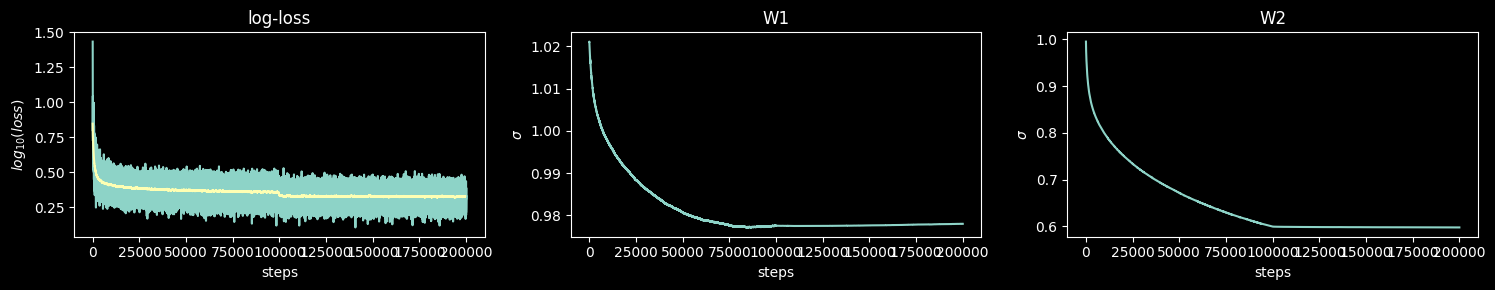

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].plot(losses)
axs[0].plot([np.mean(losses[i - 500 : i + 1]) for i in range(500, len(losses))])
axs[0].set_title('log-loss')
axs[0].set_xlabel('steps')
axs[0].set_ylabel(r'$log_{10}(loss)$')

axs[1].plot(W1_std)
axs[1].set_title('W1')
axs[1].set_xlabel('steps')
axs[1].set_ylabel(r'$\sigma$')

axs[2].plot(W2_std)
axs[2].set_title('W2')
axs[2].set_xlabel('steps')
axs[2].set_ylabel(r'$\sigma$')

plt.tight_layout()

In [14]:
@torch.no_grad()  # Decorator to disable gradient tracking
def split_loss(split: Literal['train', 'valid', 'test']) -> None:
    splits = {'train': (Xtrn, Ytrn), 'valid': (Xval, Yval), 'test': (Xtst, Ytst)}
    x, y = splits[split]
    logits = model(x)  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')


split_loss('train')
split_loss('valid')

train loss: 2.1243
valid loss: 2.1680


**Single forward pass**

In [15]:
model = MLP(vocab_size=vocab_size, block_size=block_size, emb_dim=emb_dim, hid_dim=hid_dim, seed=seed)

# Minibatch construct
ix = torch.randint(0, Xtrn.shape[0], (bs,), generator=g)
Xb, Yb = Xtrn[ix], Ytrn[ix]

# Forward pass
logits = model(Xb)
loss = F.cross_entropy(logits, Yb)

print(f'Initial loss:   {loss.item():.4f}')
print(f'Initial logits: {logits[0].tolist()}')
print(f'\u03BC: {logits[0].mean().item()}, \u03C3: {logits[0].std().item()}')


Initial loss:   26.5520
Initial logits: [12.411925315856934, -7.6996283531188965, 2.3776426315307617, 6.556832790374756, -6.789996147155762, -15.600006103515625, -21.210203170776367, -0.6893330216407776, 13.282832145690918, -12.542020797729492, -4.280671119689941, 25.916994094848633, 1.7244635820388794, -19.724594116210938, 2.658778190612793, 7.776032447814941, -15.661372184753418, 14.814678192138672, 16.635112762451172, -9.397875785827637, -6.041196823120117, -2.7173681259155273, -1.9347691535949707, -4.294508457183838, -9.465439796447754, -5.1644392013549805, 0.7409148216247559]
μ: -1.4191560745239258, σ: 11.508225440979004


The logits have quite extreme values and that create the fake confidence and high initial loss. These logits need to be much closer to 0. 

How can we do that?   

`logits = h @ W2 + b2`

- The bias `b2` is initialized with random values with mean 0 and std 1. But because we want the logits to be roughly 0's we shouldn't add a bias of random values.
- The weight `W2` is also initialized with random values. If we want the logits to be very small we also need to make the weights small.

If we would set the weight `W2` to 0's then the logits would be 0's and the loss would be exactly equal to the ideal loss of 0.29. However it's not a good idea to do that. The reason why it's better to have a bit of entropy will be explained later in this notebook.

#### Improved initialisation


In [16]:
model = MLP(vocab_size=vocab_size, block_size=block_size, emb_dim=emb_dim, hid_dim=hid_dim, seed=seed)
# Don't add b2
model.b2 = model.b2 * 0
# Make W2 very small
model.W2 = model.W2 * 0.01

# Minibatch construct
ix = torch.randint(0, Xtrn.shape[0], (bs,), generator=g)
Xb, Yb = Xtrn[ix], Ytrn[ix]

# Forward pass
logits = model(Xb)
loss = F.cross_entropy(logits, Yb)

print(f'Initial loss:   {loss.item():.4f}')
print(f'Initial logits: {logits[0].tolist()}')
print(f'\u03BC: {logits[0].mean().item()}, \u03C3: {logits[0].std().item()}')


Initial loss:   3.2939
Initial logits: [-0.03930702432990074, -0.10857903212308884, 0.08649525046348572, -0.06766287982463837, -0.0863657295703888, -0.015910087153315544, -0.09526076167821884, -0.026780564337968826, -0.06762383878231049, 0.12035798281431198, 0.019621366634964943, 0.15579168498516083, 0.04114056006073952, 0.05029834806919098, -0.08983135223388672, 0.08724547177553177, -0.22866690158843994, -0.12500609457492828, 0.10545863211154938, 0.21103426814079285, -0.08953241258859634, -0.026477359235286713, -0.19447888433933258, 0.2250606268644333, 0.04665874317288399, 0.1288319081068039, -0.06684305518865585]
μ: -0.0018641165224835277, σ: 0.11609502881765366


The logits are now much closer to 0 and the initial loss of 3.32 is very close to the ideal loss of 3.29. 

Let's now see the effect of better initialisation.

In [17]:
# Improved initialisation
model = MLP(vocab_size=vocab_size, block_size=block_size, emb_dim=emb_dim, hid_dim=hid_dim, seed=seed)
model.b2.data *= 0
model.W2.data *= 0.01

n_steps = 200001
bs = 32
losses = []

W1_std = []
W2_std = []

g = torch.Generator().manual_seed(seed)
for i in range(n_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtrn.shape[0], (bs,), generator=g)
    Xb, Yb = Xtrn[ix], Ytrn[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    model.zero_grad()
    loss.backward(retain_graph=False)  # retain_graph = True because we changed the

    # Update
    lr = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    model.optimise_step(lr)

    # Tack stats
    losses.append(loss.log10().item())
    W1_std.append(model.W1.std().item())
    W2_std.append(model.W2.std().item())

    if i % 10000 == 0:
        print(f'{i:7d}/{n_steps}: {loss.item():.4f}')

      0/200001: 3.3179
  10000/200001: 2.1848
  20000/200001: 2.3320
  30000/200001: 2.4731
  40000/200001: 1.9858
  50000/200001: 2.4827
  60000/200001: 2.1361
  70000/200001: 2.1642
  80000/200001: 2.3967
  90000/200001: 2.0793
 100000/200001: 2.4436
 110000/200001: 2.1291
 120000/200001: 2.2657
 130000/200001: 1.7314
 140000/200001: 2.1808
 150000/200001: 2.2475
 160000/200001: 2.0536
 170000/200001: 1.6976
 180000/200001: 2.4663
 190000/200001: 2.2927
 200000/200001: 1.9672


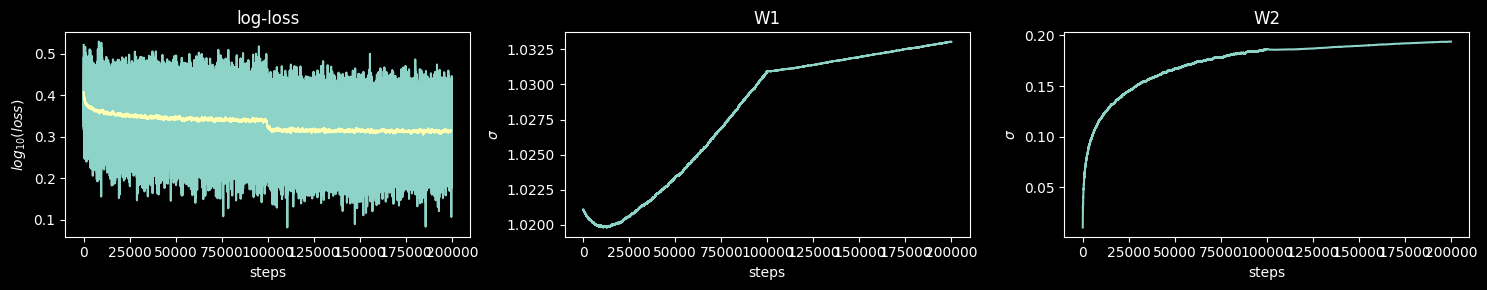

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].plot(losses)
axs[0].plot([np.mean(losses[i - 500 : i + 1]) for i in range(500, len(losses))])
axs[0].set_title('log-loss')
axs[0].set_xlabel('steps')
axs[0].set_ylabel(r'$log_{10}(loss)$')

axs[1].plot(W1_std)
axs[1].set_title('W1')
axs[1].set_xlabel('steps')
axs[1].set_ylabel(r'$\sigma$')

axs[2].plot(W2_std)
axs[2].set_title('W2')
axs[2].set_xlabel('steps')
axs[2].set_ylabel(r'$\sigma$')

plt.tight_layout()

In [19]:
@torch.no_grad()  # Decorator to disable gradient tracking
def split_loss(split: Literal['train', 'valid', 'test']) -> None:
    splits = {'train': (Xtrn, Ytrn), 'valid': (Xval, Yval), 'test': (Xtst, Ytst)}
    x, y = splits[split]
    logits = model(x)  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')


split_loss('train')
split_loss('valid')

train loss: 2.0686
valid loss: 2.1294


The plot of the loss doesn't have the hockey shape appearance because we start at a much lower loss. In the initial model the first few thousand iterations are used to bring the loss down closer to the ideal loss by shrinking the weights. With the optimised initialisation we don't spend time on this easy part but immediately start training the network.

The training loss also slightly improved from 2.12 to 2.07 and the valid loss from 2.17 to 2.13. The reason for this is that we spend more time optimizing the network instead of spending the first several thousand iterations shrinking the weights.

### Fixing tanh activation regions

Despite the promising start with an initial loss of 3.32, which is close to the ideal initial loss, there is an underlying issue within the network related to its initialization. 

The logits appear to be functioning properly, however, the problem now lies with the values of h, the activations of the hidden states.

**Visualisation of the tensor h**

In [20]:
model = MLP(vocab_size=vocab_size, block_size=block_size, emb_dim=emb_dim, hid_dim=hid_dim, seed=seed)
model(Xb)
h = model.h
h


tensor([[-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.9978, -0.9997,  ...,  0.7127,  0.9988, -0.1015],
        [-1.0000, -0.9942, -1.0000,  ..., -1.0000, -0.9995,  1.0000],
        ...,
        [-0.9716, -0.9999, -0.9919,  ..., -0.9976, -0.9999, -0.3318],
        [ 0.9923, -0.9907, -1.0000,  ..., -0.9999, -0.9476,  0.9999],
        [-0.9716, -0.9999, -0.9919,  ..., -0.9976, -0.9999, -0.3318]], grad_fn=<TanhBackward0>)

Many elements of `h` are 1 or -1. 

`h = tanh(emb @ W1 + b1)`

The activation function tanh, short for hyperbolic tangent, is a type of squashing function that maps real numbers to a range of [-1,1]. It transforms large negative numbers to values near -1 and large positive numbers to values near 1. 

The majority of values produced by the tanh activation function tend to be either -1 or 1. This can be seen by examining the distribution of `h_preact`, where the numbers range from -20 to 20. The tanh activation squashes these large numbers to -1 and 1, thus resulting in the majority of values being either -1 or 1.

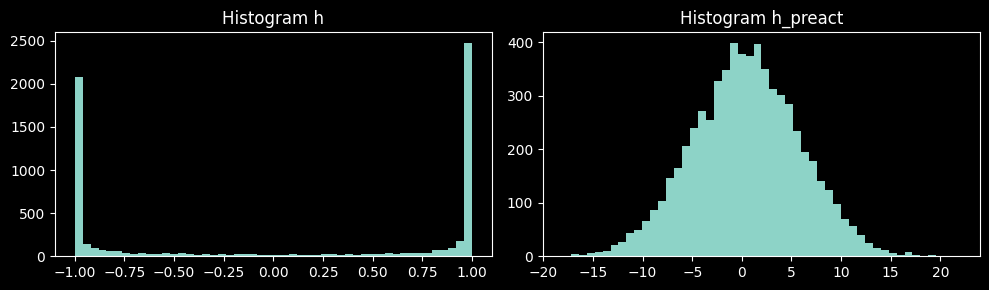

In [21]:
fig, axs =plt.subplots(1,2, figsize=(10,3))

hist = h.view(-1).tolist()  # (bs, hid_dim) -> (bs*hid_dim)
axs[0].hist(hist, bins=50)
axs[0].set_title('Histogram h')

h_preact = model.h_preact
hist = h_preact.view(-1).tolist()  # (bs, hid_dim) -> (bs*hid_dim)
axs[1].hist(hist, bins=50)
axs[1].set_title('Histogram h_preact')
plt.tight_layout()

Why is this a problem?   
During the backward pass, we begin with the loss and move backwards through the network. This includes backpropagating through the tanh function. The hidden layer of 200 neurons that use the elementwise tanh function.

```{note}
The derivative of tanh is $\Large\frac{tanh(x)}{d(x)}\large=1-tanh^2$.   
The chain rule is $\Large\frac{dy}{dx}=\frac{dy}{du} \cdot \frac{du}{dx}$ where $y = f(g(x))$ and $\frac{dy}{du} = f'(u) \quad \text{and} \quad \frac{du}{dx} = g'(x) $.
```

When the output of the tanh function is close to -1 or 1, the derivative of tanh is 0. This is due to the fact that we are in the flat region of the tanh function. As a result, small changes in the weights of the neuron do not affect the loss. This in turn stops the backpropagation process because we multiply by 0 in the chain rule. The neuron 

When the output of the tanh function is close to 0, the derivative is close to 1. The gradient just passes through because we multiply by 1 in the chain rule.


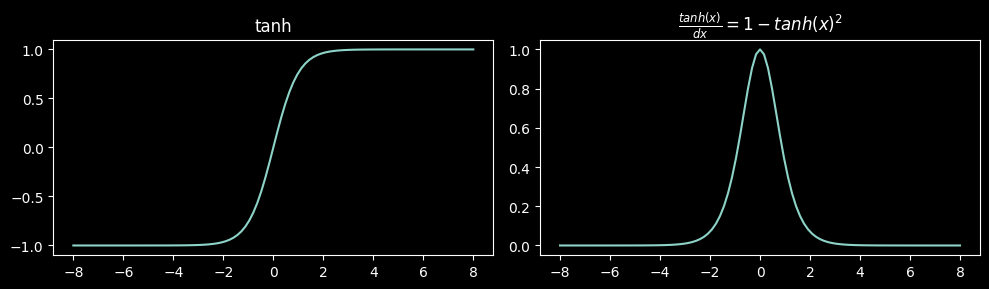

In [22]:
fig, axs =plt.subplots(1,2, figsize=(10,3))
xs = torch.linspace(-8, 8, 101)

ys = torch.tanh(xs)
axs[0].plot(xs, ys)
axs[0].set_title('tanh')

ys = 1-torch.tanh(xs)**2
axs[1].plot(xs, ys)
axs[1].set_title(r'$\frac{tanh(x)}{dx} = 1-tanh(x)^2$')

plt.tight_layout()

**Visualisation of neurons in flat region of tanh**

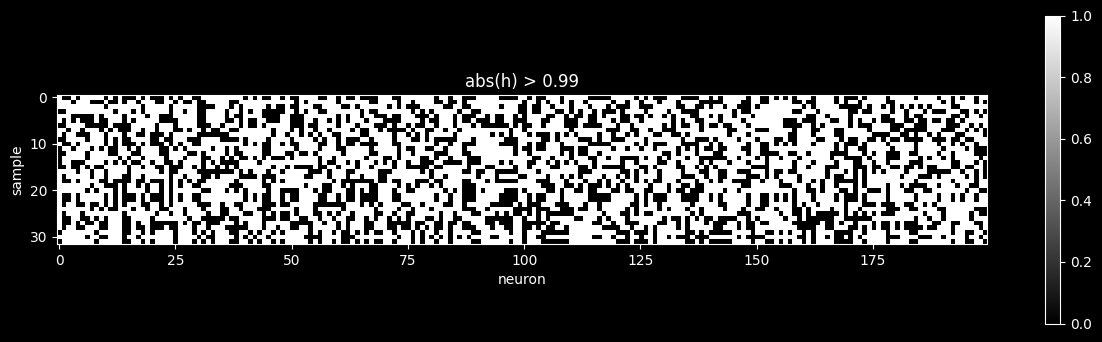

In [23]:
plt.figure(figsize=(15,4))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')
plt.title('abs(h) > 0.99')
plt.xlabel('neuron')
plt.ylabel('sample')
plt.colorbar()
plt.show()

The above image shows that there are a lot of neurons that are in the flat tails of tanh (white). The gradients during the backward pass for these neurons would be severely reduced. If an entire column is white (tanh > 0.99) for all samples, this represents a "death neuron", where no single sample ever activates the tanh in the active part of tanh. As a result, the neuron will not be able to learn during training.

Death neurons can happen if the weights of the network are initialized with very large values. It can also happen if the learning rate is set too high, which can cause the weights to become large during training. 

#### Improved model

We want less outputs of tanh to be -1 or 1. In other words, we want the pre-activation `h_preact` to be closer to 0.

How can we do that? 

`h = tanh(emb @ W1 + b1)`
- We could set the bias `b1` to 0, but it's often better to have a little entropy, so we'll set it to `b1 * 0.01`.
- We set `W1 = W1 * 0.2`.




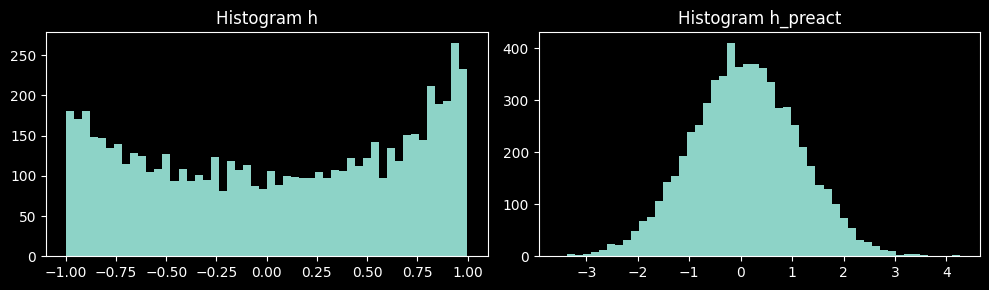

In [24]:
model = MLP(vocab_size=vocab_size, block_size=block_size, emb_dim=emb_dim, hid_dim=hid_dim, seed=seed)
# Fixing the logits
model.b2 = model.b2 * 0
model.W2 = model.W2 * 0.01
# Fixing the tanh
model.b1 = model.b1 * 0.01
model.W1 = model.W1 * 0.2

model(Xb)
h = model.h

fig, axs =plt.subplots(1,2, figsize=(10,3))

hist = h.view(-1).tolist()  # (bs, hid_dim) -> (bs*hid_dim)
axs[0].hist(hist, bins=50)
axs[0].set_title('Histogram h')

h_preact = model.h_preact
hist = h_preact.view(-1).tolist()  # (bs, hid_dim) -> (bs*hid_dim)
axs[1].hist(hist, bins=50)
axs[1].set_title('Histogram h_preact')
plt.tight_layout()

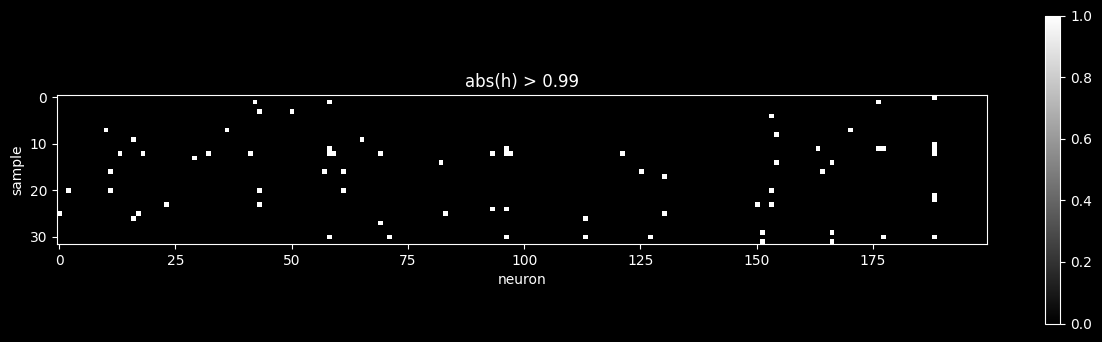

In [25]:
plt.figure(figsize=(15,4))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')
plt.title('abs(h) > 0.99')
plt.xlabel('neuron')
plt.ylabel('sample')
plt.colorbar()
plt.show()

The histogram show that `h_preact` is much closer to 0 and `h` has far less -1's and 1's.

Let's now see the effect of better initialisation.

In [26]:
# Improved initialisation
model = MLP(vocab_size=vocab_size, block_size=block_size, emb_dim=emb_dim, hid_dim=hid_dim, seed=seed)
# Fixing the logits
model.b2.data *= 0
model.W2.data *= 0.01
# Fixing the tanh
model.b1.data *= 0.01
model.W1.data *= 0.2

n_steps = 200001
bs = 32
losses = []

W1_std = []
W2_std = []

g = torch.Generator().manual_seed(seed)
for i in range(n_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtrn.shape[0], (bs,), generator=g)
    Xb, Yb = Xtrn[ix], Ytrn[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    model.zero_grad()
    loss.backward(retain_graph=False)  # retain_graph = True because we changed the

    # Update
    lr = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    model.optimise_step(lr)

    # Tack stats
    losses.append(loss.log10().item())
    W1_std.append(model.W1.std().item())
    W2_std.append(model.W2.std().item())

    if i % 10000 == 0:
        print(f'{i:7d}/{n_steps}: {loss.item():.4f}')

      0/200001: 3.3070
  10000/200001: 2.0390
  20000/200001: 2.3337
  30000/200001: 2.1899
  40000/200001: 2.0281
  50000/200001: 2.3006
  60000/200001: 1.9184
  70000/200001: 2.0165
  80000/200001: 2.1462
  90000/200001: 2.0186
 100000/200001: 2.1868
 110000/200001: 2.0560
 120000/200001: 2.0876
 130000/200001: 1.6509
 140000/200001: 2.2062
 150000/200001: 2.2495
 160000/200001: 2.0697
 170000/200001: 1.6954
 180000/200001: 2.5340
 190000/200001: 2.2555
 200000/200001: 1.8769


In [27]:
@torch.no_grad()  # Decorator to disable gradient tracking
def split_loss(split: Literal['train', 'valid', 'test']) -> None:
    splits = {'train': (Xtrn, Ytrn), 'valid': (Xval, Yval), 'test': (Xtst, Ytst)}
    x, y = splits[split]
    logits = model(x)  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')


split_loss('train')
split_loss('valid')

train loss: 2.0365
valid loss: 2.1045


The training loss slightly improved from 2.07 to 2.04 and the valid loss from 2.13 to 2.10.

```{note}
Log of losses

Original loss: 
train: 2.1243
valid: 2.1680

Fix softmax confidently wrong:
train: 2.0686
valid: 2.1294

Fix tanh layer too saturated at init:
train: 2.0365
valid: 2.1045
```
Our MLP has a simple architecture with only one layer, which makes it relatively insensitive to poor initialization. Even if our initialisation was terrible, the network was still able to learn eventually. However, this is not the case for deeper networks (e.g. 50 layers) where the impact of poor initialization can compound. The deeper and more complex the network is, the more critical the initialization becomes, and it may not be able to learn at all.